In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
from pbcpy.base import Cell
from pbcpy.grid import Grid
#

In [8]:
from pbcpy.grid_functions import Grid_Function_Base, Grid_Function, Grid_Function_Reciprocal, Grid_Space

In [9]:
from pbcpy.functionals import Functional

In [10]:
from pbcpy.local_functionals_utils import ThomasFermiEnergy, ThomasFermiPotential
from pbcpy.local_functionals_utils import vonWeizsackerEnergy, vonWeizsackerPotential

In [11]:
from pbcpy.formats.qepp import PP
from pbcpy.formats.xsf import XSF

In [12]:
mol = PP(filepp='Al_fde_rho.pp').read()

In [13]:
density = mol.plot

In [14]:
grid_real             = Grid_Space(density.grid.at,density.grid.nr)
dens_real_space       = Grid_Function(grid_real,griddata_3d=density.values)

In [15]:
ThomasFermiEnergy(dens_real_space).integral()

1.6174727743659869

In [16]:
vonWeizsackerEnergy(dens_real_space).integral()

1.961122785683175

In [17]:
v_TFvW = ThomasFermiPotential(dens_real_space).sum(vonWeizsackerPotential(dens_real_space).dot(g=1.0/9.0))

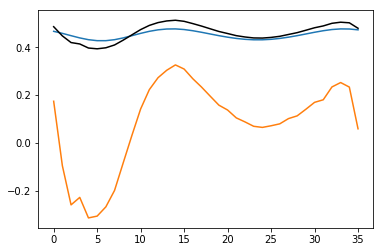

In [18]:
plt.plot(ThomasFermiPotential(dens_real_space).values[:,25,36])
plt.plot(vonWeizsackerPotential(dens_real_space).values[:,25,36])
plt.plot(v_TFvW.values[:,25,36],c='black')
#plt.ylim(-0.2,0.5)
plt.show()

In [20]:
ThomasFermi = Functional(energydensity=ThomasFermiEnergy(dens_real_space),
                         potential=ThomasFermiPotential(dens_real_space))

In [21]:
vonWeizsacker = Functional(energydensity=vonWeizsackerEnergy(dens_real_space),
                           potential=vonWeizsackerPotential(dens_real_space))

In [22]:
GEA2 = Functional(energydensity=ThomasFermiEnergy(dens_real_space).sum(
                      vonWeizsackerEnergy(dens_real_space).dot(g=1.0/9.0)),
                  potential=ThomasFermiPotential(dens_real_space).sum(
                      vonWeizsackerPotential(dens_real_space).dot(g=1.0/9.0)))

In [26]:
Energy = GEA2.energydensity.integral()
print(Energy)

1.83537530611
